# Практическая часть к занятию по искуственным нейронным сетям

### План
+ Основные концепции, применяемые в нейронных сетях
+ Полносвязная нейронная сеть
+ Сверточный слой нейронной сети
+ Cлои рекуррентной нейронной сети - RNN, LSTM
+ Применение архитектур светрочных нейронных сетей (transfer learning)

## Основы работы с нейронными сетями

Как известно из лекций, нейронные сети обучаются с помощью метода back propagation. Этот метод реализован в pytorch. Рассмотрим основные примеры автоматического вычисления градиентов.

<img src="https://blog.paperspace.com/content/images/2019/03/full_graph.png">

In [1]:
import torch

# Создаем тензор и указываем, что для него нужно строить граф вычисления с отслеживанием градиентов
x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [2]:
# Здесь y было создано как результат операции, поэтому он будет также иметь requires_grad=True
y = x - 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


In [3]:
# Тут большее количество операций с тензорами, хранящими градиент. При этом z, a также будут хранить градиенты
z = y * y * 3
a = z.mean() 

print(z)
print(a)

tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)
tensor(4.5000, grad_fn=<MeanBackward0>)


In [4]:
# Теперь применяем Backprop - считаем градиенты по графу вычислений во всех узлах графа
a.backward()

In [5]:
# Рекомендуется посчитать вручную градиент, чтобы свериться
print(x.grad)

tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])


Аналогично стоится граф вычислений и вычисляются значения градиентов для более сложных динамических функций/преобразований (например, имеющих циклы с условиями)

Для нейронной сети, как было показано на занятии, нужно использовать нелинейные функции. В pytorch имеется много встроенных реализаций функций активаций. 

In [6]:
# Например, softmax
from torch.nn.functional import softmax
x = torch.tensor([1, 2, 3], dtype=float)
y = softmax(x, dim=0)
print(y)

tensor([0.0900, 0.2447, 0.6652], dtype=torch.float64)


In [7]:
# Сигмоида
# Для функций активаций есть несколько вариантов использования - в качестве функции и в качестве модуля
from torch.nn import Sigmoid
from torch.nn.functional import sigmoid
x = torch.tensor([1, 2, 3], dtype=float)
s = Sigmoid() # создаёт nn.Module
s(x), sigmoid(x) # один результат

/Users/arkadijbessonov/miniforge3/envs/tensorflow/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(tensor([0.7311, 0.8808, 0.9526], dtype=torch.float64),
 tensor([0.7311, 0.8808, 0.9526], dtype=torch.float64))

In [8]:
# Например, th
# Обратите внимание, что в новых версиях pytorch некоторые функции активации рекомендуется 
# использовать непосредственно в виде torch.tan, без импорта из модуля torch.nn.functional
x = torch.tensor([1, 2, 3], dtype=float)
y = torch.tanh(x)
print(y)

tensor([0.7616, 0.9640, 0.9951], dtype=torch.float64)


Рассмотрим функции потерь, реализованные в pytorch

In [9]:
# MAE
input = torch.randn(3, 5)
target = torch.randn(3, 5)

loss_fn = torch.nn.L1Loss()
loss = loss_fn(input, target)
print(f'Loss = {loss}')

Loss = 0.7375168204307556


In [10]:
# MSE
input = torch.randn(3, 5)
target = torch.randn(3, 5)

loss_fn = torch.nn.MSELoss()
loss = loss_fn(input, target)
print(f'Loss = {loss}')

Loss = 1.7672799825668335


In [11]:
# Negative Log-Likelihood Loss Function
input = torch.randn(3, 5) # (B, C)
# every element in target should have 0 <= value < C
target = torch.tensor([1, 0, 4]) # метки класов

loss_fn = torch.nn.NLLLoss()
loss = loss_fn(input, target)
print(f'Loss = {loss}')

Loss = -0.1553102731704712


In [12]:
# Cross-Entropy Loss
input = torch.randn(3, 5)
target = torch.empty(3, dtype=torch.long).random_(5)

loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(input, target)
print(f'Loss = {loss}')

Loss = 1.7832330465316772


Теперь попробуем создать простую нейронную сеть, состоящую из одного нейрона - перцептрон

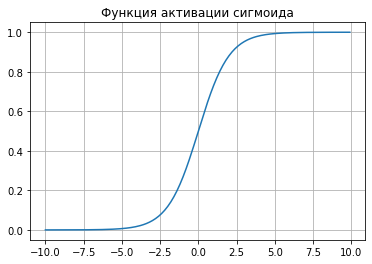

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def linear(x, weights, bias):
    """
    Функция применения линейной модели (перцептрона)
    """
    return np.dot(x, weights) + bias

def sigmoid(x):
    """
    функция активации
    """
    return 1.0 / (1.0 + np.exp(-x))

plt.plot(np.arange(-10, 10, 0.1), sigmoid(np.arange(-10, 10, 0.1)), label="sigmoid")
plt.grid()
plt.title("Функция активации сигмоида");

Будем использовать xor - простейший классический пример

In [14]:
# Создание набора для задачи xor
inputs = pd.DataFrame(
    [[0, 0],
    [0, 1],
    [1, 0],
    [1, 1]],
    columns=["Вход 1", "Вход 2"]) # Создание датасета для обучения 
inputs.index.name = "Номер наблюдения"

ground_truth = pd.Series([0, 1, 1, 0], name="Истинный выход", index=inputs.index) # Метки

print(pd.concat((inputs, ground_truth), axis=1)) # Печать датасета



                  Вход 1  Вход 2  Истинный выход
Номер наблюдения                                
0                      0       0               0
1                      0       1               1
2                      1       0               1
3                      1       1               0


In [15]:
np.random.seed(seed=17) # Для воспроизводимости
weights = np.random.rand(inputs.shape[1], 1) # Установка весов
bias = np.random.rand(1)[0] # Установка смещения

In [16]:
learning_rate = 0.05 # Установим темп обучения для градиентного спуска
NUM_ITERATIONS = 10000 # Количество итераций

In [17]:
# convert dataframe bits into arrays for processing
inputs_array = inputs.to_numpy()
truth_array = ground_truth.to_numpy().reshape(-1, 1)

x = inputs_array
for i in range(NUM_ITERATIONS):
    y = linear(x, weights, bias)
    f = sigmoid(y)

    error = np.abs(f - truth_array)

    # calculate out partial derivatives for each input
    dE_df = error/(f - truth_array)
    df_dy = sigmoid(y) * (1.0 - sigmoid(y))
    dy_dw = x
    dE_dy = dE_df * df_dy
    dE_dw = np.dot(dy_dw.T, dE_dy)  # dy_dw = x

    # update weights and biases - the error is the sum of error over each input
    weights -= learning_rate * dE_dw
    bias -= learning_rate * dE_dy.sum()

    if i % (NUM_ITERATIONS / 10) == 0:
        print("Ошибка на шаге {:5d}: {:10.2e}".format(i, error.sum()))

print("Обученные веса: {}".format(weights.flatten()))
print("Обученное смещение:    {}".format(bias))

Ошибка на шаге     0:   1.99e+00
Ошибка на шаге  1000:   1.31e+00
Ошибка на шаге  2000:   1.13e+00
Ошибка на шаге  3000:   1.08e+00
Ошибка на шаге  4000:   1.05e+00
Ошибка на шаге  5000:   1.04e+00
Ошибка на шаге  6000:   1.03e+00
Ошибка на шаге  7000:   1.03e+00
Ошибка на шаге  8000:   1.03e+00
Ошибка на шаге  9000:   1.02e+00
Обученные веса: [9.9286466  9.92866886]
Обученное смещение:    -4.498763499575384


In [18]:
predicted_output = sigmoid(linear(x, weights, bias))
predicted_output = pd.DataFrame(
    predicted_output,
    columns=["Предсказанное значение"],
    index=inputs.index)

print(predicted_output)

                  Предсказанное значение
Номер наблюдения                        
0                               0.011000
1                               0.995636
2                               0.995636
3                               1.000000


Таким образом, мы создали и обучили простейшую нейронную сеть - перцептрон. Как видно, он не смог решить задачу xor.

## Полносвязная нейронная сеть

В pytorch есть удобные методы создания собственных нейронных сетей из блоков - модулей. Для начала рассмотрим полносвязный слой.

<img src="https://miro.medium.com/max/1400/1*FlJ_ZPMSlpCdeuAYzC0gPw.png">

In [19]:
import torch

In [20]:
input_dim = 5
output_dim = 2
fc = torch.nn.Linear(input_dim, output_dim)

In [21]:
print(f'Смещение имеет размер {fc.bias.shape}')
print(f'Веса имеют размер {fc.weight.shape}, при этом признак использования графа вычислений = {fc.weight.requires_grad}')

Смещение имеет размер torch.Size([2])
Веса имеют размер torch.Size([2, 5]), при этом признак использования графа вычислений = True


Как видно, линейный слой (он же полносвязный) представляет собой пару матриц - веса и смещения. Для однослойной нейронной сети нам также необходимо использовать функцию активации. В случае простейшей архитектуры нейронной сети (последовательной) удобно пользоваться контейнером nn.Sequential, который объединяет модули последовательно. В таком случае для простейшей нейронной сети из предыдущего пункта будем иметь:

In [22]:
model = torch.nn.Sequential(
    torch.nn.Linear(inputs.shape[1], 1),
    torch.nn.Sigmoid()
)

Созданная модель в точности повторяет стуктуру предыдущего перцептрона. Инициализируем веса весами предыдущей модели

In [23]:
np.random.seed(seed=17) # То же значение
with torch.no_grad(): # Этот менеджер контекста указывает, что не нужно хранить граф вычислений.
    # torch.rand() работает быстрее, но здесь используется numpy для использования уже обученных весов
    model[0].weight = torch.nn.Parameter(torch.from_numpy(weights.T).float())
    print("Новые веса модели: {}".format(model[0].weight.flatten()))
    model[0].bias = torch.nn.Parameter(torch.tensor([bias]).float())
    print("Новое смещение: {}".format(model[0].bias.flatten()))

Новые веса модели: tensor([9.9286, 9.9287], requires_grad=True)
Новое смещение: Parameter containing:
tensor([-4.4988], requires_grad=True)


Попробуем теперь применить этот перцептрон к ем же данным, чтобы убедиться в одинаковости результатов

In [24]:
with torch.no_grad():
    predicted_output = model(torch.tensor(x).float())
    predicted_output = pd.DataFrame(
        predicted_output.numpy(),
        columns=["Предсказанное значение"],
        index=inputs.index)

    print(predicted_output)

                  Предсказанное значение
Номер наблюдения                        
0                               0.011000
1                               0.995636
2                               0.995636
3                               1.000000


Как видно, ответы совпадают. Это неудивительно, поскольку реализация полносвязного слоя nn.Linear аналогична реализованной ранее. Теперь попробуем обучить эту простейшую сеть методами pytorch, чтобы увидеть, как концептуально обучаются нейронные сети в pytorch.

In [25]:
# pytorch чувствителен к типам данных. Поэтому приведем явно к float32
inputs_tensor = torch.from_numpy(inputs.to_numpy(dtype=np.float32))
truth_tensor = torch.from_numpy(ground_truth.to_numpy(dtype=np.float32).reshape(-1, 1))

# Здесь мы используем функцию потерь из pytorch
loss = torch.nn.L1Loss(reduction='mean')

# используется SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.train()
x = inputs_tensor
for i in range(NUM_ITERATIONS):
    f = model(x)

    error = loss(f, truth_tensor)

    # удалить старые записи градиентов
    optimizer.zero_grad()

    # Вычислить значения градиентов
    error.backward()

    # Шаг оптимизатора
    optimizer.step()

    if i % (NUM_ITERATIONS / 10) == 0:
        print("Ошибка на шаге {:5d}: {:10.2e}".format(i, error.sum()))

print("Итоговые веса: {}".format(next(model.parameters()).detach().numpy().flatten()))
print("Итоговое смещение:    {}".format(list(model.parameters())[-1].item()))


Ошибка на шаге     0:   2.55e-01
Ошибка на шаге  1000:   2.55e-01
Ошибка на шаге  2000:   2.55e-01
Ошибка на шаге  3000:   2.55e-01
Ошибка на шаге  4000:   2.54e-01
Ошибка на шаге  5000:   2.54e-01
Ошибка на шаге  6000:   2.54e-01
Ошибка на шаге  7000:   2.54e-01
Ошибка на шаге  8000:   2.54e-01
Ошибка на шаге  9000:   2.54e-01
Итоговые веса: [10.409906 10.409918]
Итоговое смещение:    -4.740963459014893


In [26]:
model.eval() # это нужно, чтобы перевести модель в режим инференса
with torch.no_grad(): # чтобы не создавался граф вычислений для градиентов
    predicted_output = model(inputs_tensor).detach().numpy()
predicted_output = pd.DataFrame(
    predicted_output,
    columns=["Предсказано"],
    index=inputs.index)

print(pd.concat((
    inputs,
    ground_truth,
    predicted_output),
    axis=1))

                  Вход 1  Вход 2  Истинный выход  Предсказано
Номер наблюдения                                             
0                      0       0               0     0.008655
1                      0       1               1     0.996560
2                      1       0               1     0.996560
3                      1       1               0     1.000000


Как видно, результаты мы получили похожие (с точностью до. случайного шума). Но пока мы рассмотрели только простые однослойные сети. Для многих задач их недостаточно (например, для xor). Рассмотрим теперь многослойные сети с более сложным датасетом - mnist.

In [1]:
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch

In [2]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [16]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [4]:
# Класс - модуль, реализующий архитектуру. Можно было бы использовать nn.Sequential
class FeedforwardNeuralNetModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Первый полносвязный слой
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim) 

        # Нелинейная функция
        self.activation = torch.nn.ReLU()
        
        # Полносвязный слой
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Полносвязный слой
        out = self.fc1(x)

        # Нелинейная функция
        out = self.activation(out)

        # Полносвязный слой
        out = self.fc2(out)
        return out

In [5]:
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

In [6]:
criterion = torch.nn.CrossEntropyLoss()

In [7]:
learning_rate = 0.1
# Передаем параметры в оптимизатор, чтобы для них считались градиенты
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [27]:
iteration = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Спрямляем изображение в вектор
        images = images.view(-1, 28*28)
        break
        # Затираем прошлые градиенты, чтобы они не аккумулировались
        optimizer.zero_grad()

        # Получаем выход модели
        outputs = model(images)

        # Вычисляем значение функции потерь
        loss = criterion(outputs, labels)

        # Здесь происходит вычисление градентов для параметров модели, которые переданы в оптимизатор
        loss.backward()

        # Здесь происходит обновление параметров
        optimizer.step()

        iteration += 1

        if iteration % 500 == 0:
            # Вычисляем точность (можно пользоваться и sklearn)         
            correct = 0
            total = 0
            # Итерация по всему валидационному датасету, "переключаем" модель в режим инференса
            # (в данном случае не обязательно, но в общем случае важно не забывать)
            model.eval()
            # Поскольку нам не нужно вычисление градиентов, мы используем менеджер контекста
            with torch.no_grad():
                for images, labels in test_loader:
                    # Преобразуем изображение в вектор
                    images = images.view(-1, 28*28)

                    # Получаем выход модели
                    outputs = model(images)
                    break
#                     # Берем класс, имеющий наибольшую вероятность (здесь логиты)
#                     _, predicted = torch.max(outputs.data, 1)

#                     # Подсчитываем общее количество объектов в тестовой выборке
#                     total += labels.size(0)

#                     # Общее количество верно классифицированных объектов
#                     correct += (predicted == labels).sum()
#                 model.train()
#             accuracy = 100 * correct / total
            
#             print('Итерация: {}. Validation loss: {}. Validation accuracy: {}'.format(iteration, loss.item(), accuracy))

In [29]:
images[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0353, 0.9137, 1.0000, 0.3608, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [23]:
_, predicted = torch.max(outputs.data, 1)

In [26]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([ 8.8175, 16.6624, 10.4082, 16.4159, 12.1241, 16.2292,  7.8556, 15.3949,
        22.9453, 13.7299, 16.2733, 15.0359, 18.6604, 11.0725, 10.7063, 14.7366,
        18.2061, 12.0890, 18.1076, 17.7727, 22.4429, 22.8208, 13.5933,  9.6371,
        13.1605, 11.0427,  9.1396, 14.3041, 15.7000, 25.8716, 24.7072, 14.0563,
        12.4037,  7.0450, 21.1366, 19.8684, 17.2370,  5.2739, 14.1583, 16.2701,
        18.9942, 13.8961, 10.8279, 23.1452, 14.7524, 16.4778, 11.3257, 12.2515,
        11.1946,  7.6718, 10.4430, 11.8319, 17.3995, 20.9389, 12.5989, 15.4933,
        10.3480,  8.5560, 25.6847, 11.5854, 16.2769, 14.3239, 10.7074, 17.3756,
         5.4347, 16.2336, 14.8760, 24.4056, 17.5015, 12.1003, 25.7117, 10.3569,
        15.1009, 19.0820, 19.1648, 17.4398, 15.7087, 10.0675, 24.3996, 11.5864,
        18.3511, 16.7031, 26.9028, 14.3605, 16.8931, 10.0729, 16.1618, 12.7635,
        18.1000, 15.7945,  8.8615, 16.6904, 12.9598, 13.2796, 14.3458, 16.0358,
        1

In [24]:
predicted

tensor([5, 4, 1, 7, 8, 4, 9, 3, 3, 7, 5, 0, 6, 7, 9, 7, 6, 9, 2, 8, 2, 0, 3, 7,
        1, 1, 1, 4, 2, 3, 2, 8, 5, 8, 4, 2, 2, 5, 8, 6, 6, 9, 1, 3, 6, 4, 1, 9,
        8, 5, 1, 0, 7, 4, 8, 5, 1, 3, 3, 9, 5, 8, 1, 2, 6, 9, 4, 3, 6, 5, 3, 1,
        7, 7, 2, 3, 6, 3, 5, 1, 8, 3, 5, 9, 5, 1, 9, 5, 6, 3, 4, 7, 2, 7, 9, 6,
        3, 1, 7, 2])

In [20]:
labels

tensor([3, 4, 1, 7, 8, 4, 9, 3, 3, 7, 5, 0, 6, 7, 9, 7, 6, 9, 2, 8, 2, 0, 3, 7,
        1, 1, 1, 4, 2, 3, 2, 8, 5, 1, 4, 2, 2, 5, 8, 6, 6, 9, 1, 3, 6, 4, 1, 9,
        8, 5, 1, 0, 7, 4, 8, 5, 1, 3, 3, 9, 5, 8, 1, 2, 6, 9, 4, 3, 6, 5, 3, 1,
        7, 7, 2, 3, 6, 3, 5, 1, 8, 3, 5, 9, 5, 1, 9, 5, 6, 3, 4, 7, 2, 7, 9, 6,
        3, 1, 7, 2])

Подход, продемонстрированный выше, является универсальным. В общем случае любуюнейронную сеть, написанную с помощью pytorch, можно обучать таким образом.

## Сверточные слои

Выше для работы с изображениями была использована довольно простая полносвязная нейронная сеть. Точность такой модели достаточно высока. 

Тем не менее, полносвязные сети для изображений применять крайне неэффективно (вспомните материалы лекции, почему это так?). В данном случае картинки достаточно маленькие. Для более сложных задач на практике широко применяют сверточные нейронные сети. Рассмоотрим основные методы работы со сверточными слоями.

<img src="https://controlandlearning.files.wordpress.com/2020/07/figure-1.png">

In [35]:
import torch
x = torch.Tensor([1, 2, 3, 4, 5, 5, 4, 3, 2, 1]).view(1,1,10)
c = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, bias=False) # 1d свертка
c.weight = torch.nn.Parameter(torch.Tensor([-1, 0, 1]).view(1,1,3))
c.weight.data.copy_(torch.tensor([-1, 0, 1])) 
c(x)

tensor([[[ 2.,  2.,  2.,  1., -1., -2., -2., -2.]]],
       grad_fn=<ConvolutionBackward0>)

Выше показан пример применения 1d свертки в pytorch. Проверьте, что результат применения согласуется с тем, что ожидается. Похожим образом работает и 2d свертка

<img src="https://www.tutorialexample.com/wp-content/uploads/2020/08/Understand-tf.nn_.conv2d-Compute-a-2-D-Convolution-in-TensorFlow.png">

In [36]:
x = torch.randn(20, 16, 50, 100)
# В свертке используем 16 входных каналов, 33 выходных и ядро (3,5) со страйдом (2,1). 
# Также используется паддинг (4, 2) и dilation (3, 1)
m = torch.nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1)) 
output = m(x) # проверьте себя - какой будет разметрость output

Напомним, что dilation указывает, с каким расстоянием между "пикселями" по каждой оси будет рецептивное поле нейрона сверточной сети

In [37]:
output.shape

torch.Size([20, 33, 26, 100])

Также в сверточных сетях часто встречается модуль пулинга. Как правило, он используется для снижения размеров входного тензора и, таким образом, уменьшения количества параметров модели.

<img src="https://www.researchgate.net/profile/Nura-Aljaafari/publication/332092821/figure/fig4/AS:779719519764482@1562911028330/Example-of-max-pooling-and-average-pooling-operations-In-this-example-a-4x4-image-is.jpg">

In [38]:
x = torch.randn(20, 16, 50, 32)
m = torch.nn.MaxPool2d((3, 2), stride=(2, 1)) # используем ядро (3,2) и страйд (2,1) 
output = m(x) # проверьте себя - какой будет разметрость output

In [39]:
output.shape

torch.Size([20, 16, 24, 31])

У большинства функциональных модулей есть аналоги - функции. Например, для пулинга

In [40]:
output_functional = torch.nn.functional.max_pool2d(x, kernel_size=(3,2), stride=(2,1))
print(f'output == output_functional = {(output == output_functional).all()}')

output == output_functional = True


Помимо макспулинга есть и другие, наиболее популярный - AvgPool2d. Как следует из названия, вместо максимума по элементам в нем берется среднее значение. 

Построим теперь свою сверточную сеть. Будем использовать набор данных Fashion mnist.

In [41]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [42]:
# Опредение набора преобразований - преобразование в тензор и нормализация изображений
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Загрузка данных
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



Каждое изображение имеет размер torch.Size([1, 28, 28])


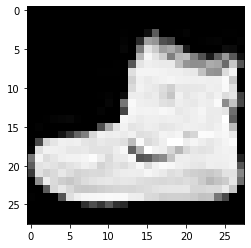

In [43]:
# Изобразим элемент выборки
image, labels = trainset[0]
print(f'Каждое изображение имеет размер {image.shape}')
plt.imshow(image.numpy().squeeze(), cmap = 'Greys_r')

In [44]:
# Простейшая трехслойная модель с использованием сверточных слоев
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(3,3)),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(3,3), stride=(1,1)),
    torch.nn.Dropout(0.2),
    torch.nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(4, 4)),
    torch.nn.Dropout(0.2),
    torch.nn.Flatten(),
    torch.nn.LogSoftmax(dim = 1)
)

In [45]:
# Опередение функции потерь
criterion = torch.nn.NLLLoss()

# Определение оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

# Количество эпох, используемое для обучения
epochs = 15

train_losses, test_losses = [], []

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Если доступна видеокарта, то обучение на ней быстрее
model = model.to(device) # При обучении на гпу модель должна храниться на гпу

In [47]:
model.train()
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        # Очищаем градиенты с прошлого шага
        optimizer.zero_grad()

        output = model.forward(images.to(device))
        loss = criterion(output, labels.to(device))
        loss.backward()
        optimizer.step()
    
        running_loss += loss.cpu().item()
    else:
        test_loss = 0
        accuracy = 0
    
        # На валидации не нужно считать градиенты
        with torch.no_grad():
      
            model.eval()
      
            # Считаем значение функции потерь и точность на валидационной выборке
            for images, labels in testloader:
                log_ps = model(images.to(device))
                test_loss += criterion(log_ps, labels.to(device)).cpu().item()
                # Преобразование в вероятности и подсчет точности 
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class.cpu() == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
              "Test loss: {:.3f}..".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15.. Training loss: 0.824.. Test loss: 0.462.. Test Accuracy: 0.834
Epoch: 2/15.. Training loss: 0.648.. Test loss: 0.383.. Test Accuracy: 0.868
Epoch: 3/15.. Training loss: 0.610.. Test loss: 0.374.. Test Accuracy: 0.866
Epoch: 4/15.. Training loss: 0.586.. Test loss: 0.338.. Test Accuracy: 0.880
Epoch: 5/15.. Training loss: 0.578.. Test loss: 0.353.. Test Accuracy: 0.877
Epoch: 6/15.. Training loss: 0.561.. Test loss: 0.332.. Test Accuracy: 0.881
Epoch: 7/15.. Training loss: 0.552.. Test loss: 0.324.. Test Accuracy: 0.884
Epoch: 8/15.. Training loss: 0.549.. Test loss: 0.337.. Test Accuracy: 0.882
Epoch: 9/15.. Training loss: 0.544.. Test loss: 0.326.. Test Accuracy: 0.885
Epoch: 10/15.. Training loss: 0.537.. Test loss: 0.328.. Test Accuracy: 0.881
Epoch: 11/15.. Training loss: 0.531.. Test loss: 0.321.. Test Accuracy: 0.885
Epoch: 12/15.. Training loss: 0.529.. Test loss: 0.322.. Test Accuracy: 0.882
Epoch: 13/15.. Training loss: 0.524.. Test loss: 0.324.. Test Accuracy: 0

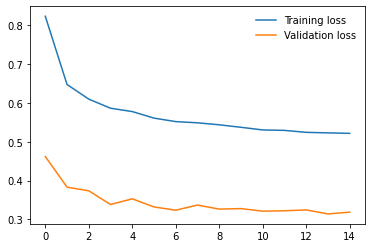

In [48]:
# Построение графика значений функции потерь на обучающей и тестовой выборках в зависимости от эпохи

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

Видно, что из-за использования дропаута значение функции потерь на валидационной выборке больше, чем на тренировочной

In [49]:
# Функция для визуализации
def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['Футболка',
                            'Брюки',
                            'Пуловер',
                            'Платье',
                            'Пальто',
                            'Сандалии',
                            'Рубашка',
                            'Кроссовки',
                            'Сумка',
                            'Ботильоны'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

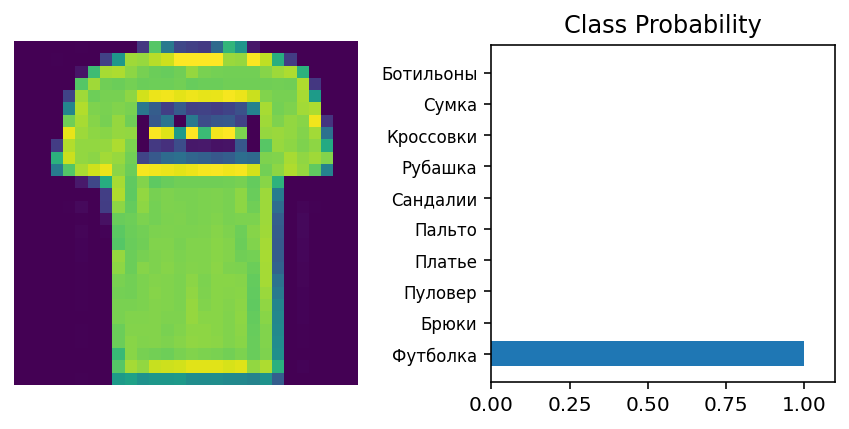

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Выбираем картинку из обучающего набора данных
img, label = trainset[1]

model.eval()
with torch.no_grad():
    # Вычисляем вероятности
    ps = torch.exp(model(img.to(device).unsqueeze(0))).cpu()

    
# Построение верооятностного распределения
view_classify(img, ps, version='Fashion')

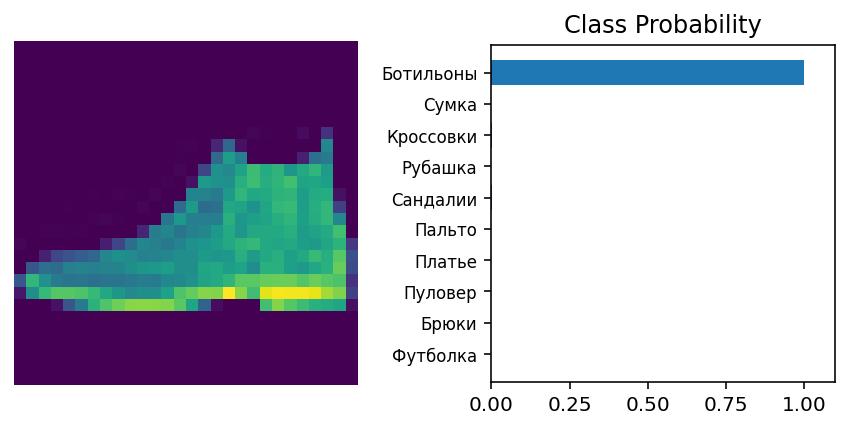

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Выбираем картинку из тестового набора данных
img, label = testset[0]

model.eval()
with torch.no_grad():
    # Вычисляем вероятности
    ps = torch.exp(model(img.to(device).unsqueeze(0))).cpu()

# Построение верооятностного распределения
view_classify(img, ps, version='Fashion')

Таким образом, сверточные нейронные сети хорошо подходят для работы с изображениями. Но для более сложных наборов данных, содержащих большие картинки, обучать самостоятельно нейронную сеть становится вычислительно сложнее. В таком случае на практике используют предобученные архитекруты нейронных сетей.

## Рекуррентные нейронные сети

In [52]:
import os
import torch
import numpy as np
import random 
import torch.nn as nn
import torchvision

def set_seed(seed = 417):
    '''Для воспроизводимости'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()


In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используется ', device)

Используется  cuda


RNN моделируют последовательные данные, то есть имеют последовательную память. RNN принимает входные данные различного типа (текст, слова, буквы, части изображения, звуки и т.д.) и возвращает в общем виде последовательность.
<img src="https://www.researchgate.net/publication/318332317/figure/fig1/AS:614309562437664@1523474221928/The-standard-RNN-and-unfolded-RNN.png">

Как работает RNN:

1. Использует предыдущую информацию, чтобы влиять на новые выходы
2. Есть 3 основных вектора: входной, выходной и скрытое состояние (где хранится информация)
3. Информация о предыдущих входах хранится в скрытом состоянии
4. Есть только 3 матрицы (U, V, W), которые содержат веса в качестве параметров. Они НЕ меняются при вводе, они остаются неизменными на протяжении всей последовательности.

Применим рекуррентную нейронную сеть для классификации рукописных цифр

In [54]:
# Модель нейронной сети
class VanillaRNN_MNIST(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, output_size):
        super(VanillaRNN_MNIST, self).__init__()
        self.batch_size, self.input_size, self.hidden_size, self.output_size = batch_size, input_size, hidden_size, output_size
        
        # RNN слой
        self.rnn = nn.RNN(input_size, hidden_size)
        # Полносвязный слой для классификации
        self.layer = nn.Linear(hidden_size, self.output_size)
    
    def forward(self, images, prints=False):
        if prints: print('Размер исходного изображения:', images.shape)
        
        images = images.permute(1, 0, 2)
        if prints: print('Размер изображения после перестановки:', images.shape)
        
        # Инициализируем начальное скрытое состояние нулями
        hidden_state = torch.zeros(1, self.batch_size, self.hidden_size).to(device)
        if prints: print('Размерность скрытого состояния:', hidden_state.shape)
        
        # Применение RNN
        hidden_outputs, hidden_state = self.rnn(images, hidden_state)
        
        # Вычисление логитов
        out = self.layer(hidden_state)
        
        if prints:
            print('----Размерность скрытого состояния:', hidden_state.shape, '\n' +
                  '----Размер выхода:', out.shape)
        
        # Изменение размерности
        out = out.view(-1, self.output_size)
        if prints: print('Итоговая размерность:', out.shape)
        
        return out

In [55]:
batch_size = 64        # Размер батча
input_size = 28        # Изображения 28 на 28
hidden_size = 150      # Размерность скрытого состояния
output_size = 10       # 10 различных цифр - классов

In [56]:
my_transform = transforms.Compose([transforms.ToTensor()])

# Загрузка данных
mnist_train = torchvision.datasets.MNIST('data', train = True, download=True, transform=my_transform)
mnist_test = torchvision.datasets.MNIST('data', train = False, download=True, transform=my_transform)

In [57]:
# Создание загрузчика
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64)

# Выбираем один батч
images_example, labels_example = next(iter(train_loader))
print('Размер исходного изображения:', images_example.shape)

# Изменить размеры
images_example = images_example.view(-1, 28, 28)
print('Измененный размер изображения:', images_example.shape)
print('Размер меток:', labels_example.shape, '\n')
# Создание модели
model_example = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size).to(device)


out = model_example(images_example.to(device), prints=True)

Размер исходного изображения: torch.Size([64, 1, 28, 28])
Измененный размер изображения: torch.Size([64, 28, 28])
Размер меток: torch.Size([64]) 

Размер исходного изображения: torch.Size([64, 28, 28])
Размер изображения после перестановки: torch.Size([28, 64, 28])
Размерность скрытого состояния: torch.Size([1, 64, 150])
----Размерность скрытого состояния: torch.Size([1, 64, 150]) 
----Размер выхода: torch.Size([1, 64, 10])
Итоговая размерность: torch.Size([64, 10])


In [58]:
def get_accuracy(out, actual_labels, batchSize):
    '''Вычисление точности классификации с использованием логитов'''
    predictions = out.max(dim=1)[1]
    correct = (predictions == actual_labels).sum().item()
    accuracy = correct/batch_size
    
    return accuracy

In [59]:
def train_network(model, train_data, test_data, batchSize=64, num_epochs=1, learning_rate=0.001):
    
    '''Эта функция обучает модель и вычисляет среднюю точность на тренировочной и тестовой выборках'''
    # Тут создается загрузчик 
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batchSize, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batchSize, shuffle=True, drop_last=True)
    
    # Объявление оптимизатора и функции потерь
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    print('Начало обучения...')
    # Цикл по эпохам
    for epoch in range(num_epochs):
        
        # Сохранить значение метрик
        train_loss = 0
        train_acc = 0
        
        # Модель в режим обучения
        model.train()
        
        for k, (images, labels) in enumerate(train_loader):
            
            # спрямить изображение в вектор
            images = images.view(-1, 28, 28)
            
            # вычисление логитов
            out = model(images.to(device))
            # Очистка градиентов
            optimizer.zero_grad()
            # Вычисление функции потерь
            loss = criterion(out, labels.to(device))
            # Вычисление градиентов
            loss.backward()
            # Обновление весов
            optimizer.step()
            
            # Сохранить метрики
            train_loss += loss.cpu().item()
            train_acc += get_accuracy(out, labels.to(device), batchSize)
            
        
        print('TRAIN | Epoch: {}/{} | Loss: {:.2f} | Accuracy: {:.2f}'.format(epoch+1, num_epochs, train_loss/k, train_acc/k))
            
            
    print('Начало тестирования...')
    test_acc = 0
    # Режим инференса
    model.eval()
    
    for k, (images, labels) in enumerate(test_loader):
        # Спрямление изображения в вектор
        images = images.view(-1, 28, 28)
        out = model(images.to(device))
        # Добавить значение точности
        test_acc += get_accuracy(out, labels.to(device), batchSize)
        
    print('TEST | Average Accuracy per {} Loaders: {:.5f}'.format(k, test_acc/k) )

In [60]:
batch_size=64
input_size=28
hidden_size=150
output_size=10

# Объявление модели
vanilla_rnn = VanillaRNN_MNIST(batch_size, input_size, hidden_size, output_size)
vanilla_rnn = vanilla_rnn.to(device)
# Обучение
train_network(vanilla_rnn, mnist_train, mnist_test, num_epochs=10)

Начало обучения...
TRAIN | Epoch: 1/10 | Loss: 0.73 | Accuracy: 0.76
TRAIN | Epoch: 2/10 | Loss: 0.32 | Accuracy: 0.91
TRAIN | Epoch: 3/10 | Loss: 0.24 | Accuracy: 0.93
TRAIN | Epoch: 4/10 | Loss: 0.20 | Accuracy: 0.94
TRAIN | Epoch: 5/10 | Loss: 0.17 | Accuracy: 0.95
TRAIN | Epoch: 6/10 | Loss: 0.16 | Accuracy: 0.96
TRAIN | Epoch: 7/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 8/10 | Loss: 0.13 | Accuracy: 0.96
TRAIN | Epoch: 9/10 | Loss: 0.13 | Accuracy: 0.96
TRAIN | Epoch: 10/10 | Loss: 0.13 | Accuracy: 0.96
Начало тестирования...
TEST | Average Accuracy per 155 Loaders: 0.97228


Теперь посмотрим, как работают многослойные рекуррентные нейронные сети.
Они нужны для создания абстракций более высокого уровня и фиксации большего количества нелинейностей между данными. Однако они сложнее обучаются.
<img src="https://i.imgur.com/oyhyofT.png">

In [61]:
class MultilayerRNN_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, relu=True):
        super(MultilayerRNN_MNIST, self).__init__()
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        
        # Создать RNN
        if relu:
            self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='relu')
        else:
            self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='tanh')
            
        # Создать FNN
        self.fnn = nn.Linear(hidden_size, output_size)
        
    def forward(self, images, prints=False):
        if prints: print('iРазмер изображения:', images.shape)
        
        # Инициализация начального скрытого состояния
        hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size)
        hidden_state = hidden_state.requires_grad_().to(device)
        if prints: print('Размерность скрытого состояния:', hidden_state.shape)
        
        # вычисление RNN
        output, last_hidden_state = self.rnn(images.to(device), hidden_state.detach().to(device))
        if prints: print('RNN размерность выхода:', output.shape, '\n' +
                         'RNN размерность последнего скрытого состояния', last_hidden_state.shape)
        
        # Вычисление FNN
        output = self.fnn(output[:, -1, :])
        if prints: print('FNN размерность выхода:', output.shape)
        
        return output

In [62]:
batch_size = 64
input_size = 28
hidden_size = 100      # количество нейронов
layer_size = 2         # количество слоев
output_size = 10

In [63]:
train_loader_example = torch.utils.data.DataLoader(mnist_train, batch_size=64)

# Пример батча
images, labels = next(iter(train_loader_example))
print('original images shape:', images.shape)

# Преобразование изображения в вектор
images = images.reshape(-1, 28, 28)
print('reshaped images shape:', images.shape, '\n')

# Создание модели
multilayer_rnn_example = MultilayerRNN_MNIST(input_size, hidden_size, layer_size, output_size, relu=False).to(device)
print(multilayer_rnn_example)

out = multilayer_rnn_example(images.to(device), prints=True)

original images shape: torch.Size([64, 1, 28, 28])
reshaped images shape: torch.Size([64, 28, 28]) 

MultilayerRNN_MNIST(
  (rnn): RNN(28, 100, num_layers=2, batch_first=True)
  (fnn): Linear(in_features=100, out_features=10, bias=True)
)
iРазмер изображения: torch.Size([64, 28, 28])
Размерность скрытого состояния: torch.Size([2, 64, 100])
RNN размерность выхода: torch.Size([64, 28, 100]) 
RNN размерность последнего скрытого состояния torch.Size([2, 64, 100])
FNN размерность выхода: torch.Size([64, 10])


In [64]:
batch_size = 64
input_size = 28
hidden_size = 100  
layer_size = 2         
output_size = 10

# Создание модели
multilayer_rnn = MultilayerRNN_MNIST(input_size, hidden_size, layer_size, output_size, relu=False).to(device)

train_network(multilayer_rnn, mnist_train, mnist_test, num_epochs=10)

Начало обучения...
TRAIN | Epoch: 1/10 | Loss: 0.68 | Accuracy: 0.77
TRAIN | Epoch: 2/10 | Loss: 0.26 | Accuracy: 0.93
TRAIN | Epoch: 3/10 | Loss: 0.19 | Accuracy: 0.95
TRAIN | Epoch: 4/10 | Loss: 0.16 | Accuracy: 0.95
TRAIN | Epoch: 5/10 | Loss: 0.14 | Accuracy: 0.96
TRAIN | Epoch: 6/10 | Loss: 0.12 | Accuracy: 0.97
TRAIN | Epoch: 7/10 | Loss: 0.13 | Accuracy: 0.96
TRAIN | Epoch: 8/10 | Loss: 0.11 | Accuracy: 0.97
TRAIN | Epoch: 9/10 | Loss: 0.10 | Accuracy: 0.97
TRAIN | Epoch: 10/10 | Loss: 0.11 | Accuracy: 0.97
Начало тестирования...
TEST | Average Accuracy per 155 Loaders: 0.98014


Основная проблема RNN:

Имеет кратковременную память, вызванную проблемой затухания градиентов - поскольку RNN имеет больше шагов (временных меток), становится все труднее сохранять информацию с предыдущих шагов. Решение этой проблемы лежит в основе идеи LSTM.

LSTM сложнее, чем простая RNN - слой состоит из cell state и gates.
У этого слоя есть свойство -  запоминать и забывать избыточную информацию.
Он использует функции sigmoid.


У ячейки LSTM есть 2 выхода: состояние ячейки и скрытое состояние.
Forget gate $(X_{t} + h_{t-1})$: решает, какую информацию забыть - значенияближе к 0 означают, что прошлая информация должна удаляться.
Input gate $(X_{t} + h_{t-1})$ отвечает за то, какую часть информации на данном шаге нужно оставить для предыдущего шага.
Текущее состояние ячейки: $f_t*C_{t-1} + i_t*C_t$
Output Gate $((X_{t} + h_{t-1}) * C_t)$ решает, каким должно быть следующее скрытое состояние (которое содержит информацию о предыдущих входах)

Сети с LSTM также могут быть *многослойными*. 

*Двунаправленные LSTM*: являются расширением традиционных LSTM, которые могут улучшить производительность модели при решении задач классификации последовательностей. Они обучают модель вперед и назад на одном и том же входе (поэтому для 1 слоя LSTM мы получаем 2 скрытых состояния и состояния ячейки).

<img src="https://i.stack.imgur.com/iIiYO.png">

In [65]:
class LSTM_MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, bidirectional=True):
        super(LSTM_MNIST, self).__init__()
        
        self.input_size, self.hidden_size, self.layer_size, self.output_size = input_size, hidden_size, layer_size, output_size
        self.bidirectional = bidirectional
        
        # Инициализация LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        
        # Инициализация FNN
        if bidirectional: # we'll have 2 more layers
            self.layer = nn.Linear(hidden_size*2, output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)
            
            
    def forward(self, images, prints=False):
        if prints: print('images shape:', images.shape)
        
        # Установить начальные состояния
        if self.bidirectional:
            # Скрытое состояние:
            hidden_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size).to(device)
            # Состояние ячейки:
            cell_state = torch.zeros(self.layer_size*2, images.size(0), self.hidden_size).to(device)
        else:
            # Скрытое состояние:
            hidden_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size).to(device)
            # Состояние ячейки:
            cell_state = torch.zeros(self.layer_size, images.size(0), self.hidden_size).to(device)
        if prints: print('hidden_state t0 имеет размерность:', hidden_state.shape, '\n' +
                         'cell_state t0 имеет размерность:', cell_state.shape)
        
        # LSTM:
        output, (last_hidden_state, last_cell_state) = self.lstm(images.to(device), (hidden_state, cell_state))
        if prints: print('LSTM: размерность выхода:', output.shape, '\n' +
                         'LSTM: размерность last_hidden_state:', last_hidden_state.shape, '\n' +
                         'LSTM: размерность last_cell_state:', last_cell_state.shape)
        # Изменение размерности
        output = output[:, -1, :]
        if prints: print('Изменение размерности выхода:', output.shape)
        
        # FNN:
        output = self.layer(output)
        if prints: print('FNN: Итоговая размерность:', output.shape)
        
        return output

In [66]:
batch_size = 64
input_size = 28       # ширина изображения
hidden_size = 128     # Количество нейронов
layer_size = 2        # Количество слоев
output_size = 10      # Количество классов

In [67]:
# Пример батча
images, labels = next(iter(train_loader_example))
print('Размер исходного изображения:', images.shape)
# Преобразование изображения в вектор
images = images.reshape(-1, 28, 28)
print('Размер преобразованного изображения:', images.shape, '\n')

# Создание модели
lstm_example = LSTM_MNIST(input_size, hidden_size, layer_size, output_size).to(device)
print('lstm_example:', lstm_example, '\n')

out = lstm_example(images.to(device), prints=True)

Размер исходного изображения: torch.Size([64, 1, 28, 28])
Размер преобразованного изображения: torch.Size([64, 28, 28]) 

lstm_example: LSTM_MNIST(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True, bidirectional=True)
  (layer): Linear(in_features=256, out_features=10, bias=True)
) 

images shape: torch.Size([64, 28, 28])
hidden_state t0 имеет размерность: torch.Size([4, 64, 128]) 
cell_state t0 имеет размерность: torch.Size([4, 64, 128])
LSTM: размерность выхода: torch.Size([64, 28, 256]) 
LSTM: размерность last_hidden_state: torch.Size([4, 64, 128]) 
LSTM: размерность last_cell_state: torch.Size([4, 64, 128])
Изменение размерности выхода: torch.Size([64, 256])
FNN: Итоговая размерность: torch.Size([64, 10])


In [68]:
batch_size = 64
input_size = 28
hidden_size = 100  
layer_size = 2         
output_size = 10

# Объявление модели
lstm_rnn = LSTM_MNIST(input_size, hidden_size, layer_size, output_size).to(device)

train_network(lstm_rnn, mnist_train, mnist_test, num_epochs=10)

Начало обучения...
TRAIN | Epoch: 1/10 | Loss: 0.46 | Accuracy: 0.85
TRAIN | Epoch: 2/10 | Loss: 0.12 | Accuracy: 0.96
TRAIN | Epoch: 3/10 | Loss: 0.08 | Accuracy: 0.98
TRAIN | Epoch: 4/10 | Loss: 0.06 | Accuracy: 0.98
TRAIN | Epoch: 5/10 | Loss: 0.05 | Accuracy: 0.98
TRAIN | Epoch: 6/10 | Loss: 0.05 | Accuracy: 0.99
TRAIN | Epoch: 7/10 | Loss: 0.04 | Accuracy: 0.99
TRAIN | Epoch: 8/10 | Loss: 0.03 | Accuracy: 0.99
TRAIN | Epoch: 9/10 | Loss: 0.03 | Accuracy: 0.99
TRAIN | Epoch: 10/10 | Loss: 0.02 | Accuracy: 0.99
Начало тестирования...
TEST | Average Accuracy per 155 Loaders: 0.99264


Как видно, получены довольно хорошие результаты. Сравните данный результат с предыдущими (включая результаты предыдущих разделов). Как вы думаете, почему так могло получиться?

## Применение архитектур сверточных сетей

In [69]:
!cp ../input/dogs-vs-cats-redux-kernels-edition/train.zip train.zip 

In [70]:
!unzip -q train.zip 

В практических задачах часто не достаточно данных для обучения сложной модели. В таких случаях хорошо работает подход с использованием transfer learning. В этом случае мы дообучаем модель, обученную на других данных, для своей задачи. В данном примере будет рассмотрена простейшая задача классификации кошек и собак. Для того, чтобы повторить выполнение кода необходимо скачать данные с  [сайта](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition), разархивировать папку train и указать путь к ней.

In [71]:
TRAIN_FOLDER_PATH = '/kaggle/working/train' # put your path here

In [72]:
import copy
import glob
import multiprocessing
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [73]:
input_size = 224 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Количество классов
num_classes = 2 # dog, cat

batch_size = 32

num_epochs = 2

# Флаг извлечения признаков. Если True, то обновляются только веса измененного слоя. Иначе - вся модель
feature_extract = True

# Будем использовать параллельную загрузку данных
num_workers = multiprocessing.cpu_count()

In [74]:
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

In [75]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    history = {'accuracy': [],
               'val_accuracy': [],
               'loss': [],
               'val_loss': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Обучение и валидация на каждой эпохе
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # На обучающей фаззе
            else:
                model.eval()   # На валидационной

            running_loss = 0.0
            running_corrects = 0

            # Итерация по загрузчику
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Занулить градиенты
                optimizer.zero_grad()

                # прямой проход с вычислением функции потерь
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # вычисление градиентов
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # статистики
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Сохраняем лучшую модель на валидации, сохранияем значения метрик
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['accuracy'].append(epoch_acc.item())
                history['loss'].append(epoch_loss)
            else:
                history['val_accuracy'].append(epoch_acc.item())
                history['val_loss'].append(epoch_loss) 

        print() # пустая строка

    print('Best val Acc: {:4f}'.format(best_acc))

    # Загрузка лучшей модели
    model.load_state_dict(best_model_wts)
    return model, history

In [76]:
all_train_files = glob.glob(os.path.join(TRAIN_FOLDER_PATH, '*.jpg'))
train_list, val_list = train_test_split(all_train_files, random_state=42)

In [77]:
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

In [78]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [79]:
# Создание датасетов
image_datasets = {
    'train': DogVsCatDataset(train_list,
                             transform=data_transforms['train']),
    'val': DogVsCatDataset(val_list,
                           transform=data_transforms['val'])
}

# Создание загрузчиков
dataloaders_dict = {x: DataLoader(image_datasets[x],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers) for x in ['train', 'val']}

# Определяем доступность гпу. Поскольку модель довольно большая, обучать ее лучше на графическом процессоре
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Будем использовать для примера архитектуру VGG16, которая была на лекции

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network-1.jpg">

In [80]:
model_ft = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Для задачи будем менять верхние слои, отвечающие за высокоуровневые признаки. В данном примере мы поменяем последний полносвязный слой, который будет иметь в нашем случае два класса вместо 1000. Посмотрим, как выглядит классификатор

In [81]:
model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

Теперь поменяем последний слой

In [82]:
model_ft.classifier[6] = nn.Linear(4096, num_classes)

In [83]:
model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [84]:
# Нужно перенести модель на используемое устройство
model_ft = model_ft.to(device)

# Обучаем либо все параметры, либо только добавленные
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Передаем параметры в оптимизатор
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [85]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/1
----------


  0%|          | 0/586 [00:00<?, ?it/s]

train Loss: 0.0523 Acc: 0.9804


  0%|          | 0/196 [00:00<?, ?it/s]

val Loss: 0.0334 Acc: 0.9893

Epoch 1/1
----------


  0%|          | 0/586 [00:00<?, ?it/s]

train Loss: 0.0296 Acc: 0.9892


  0%|          | 0/196 [00:00<?, ?it/s]

val Loss: 0.0314 Acc: 0.9904

Best val Acc: 0.990400


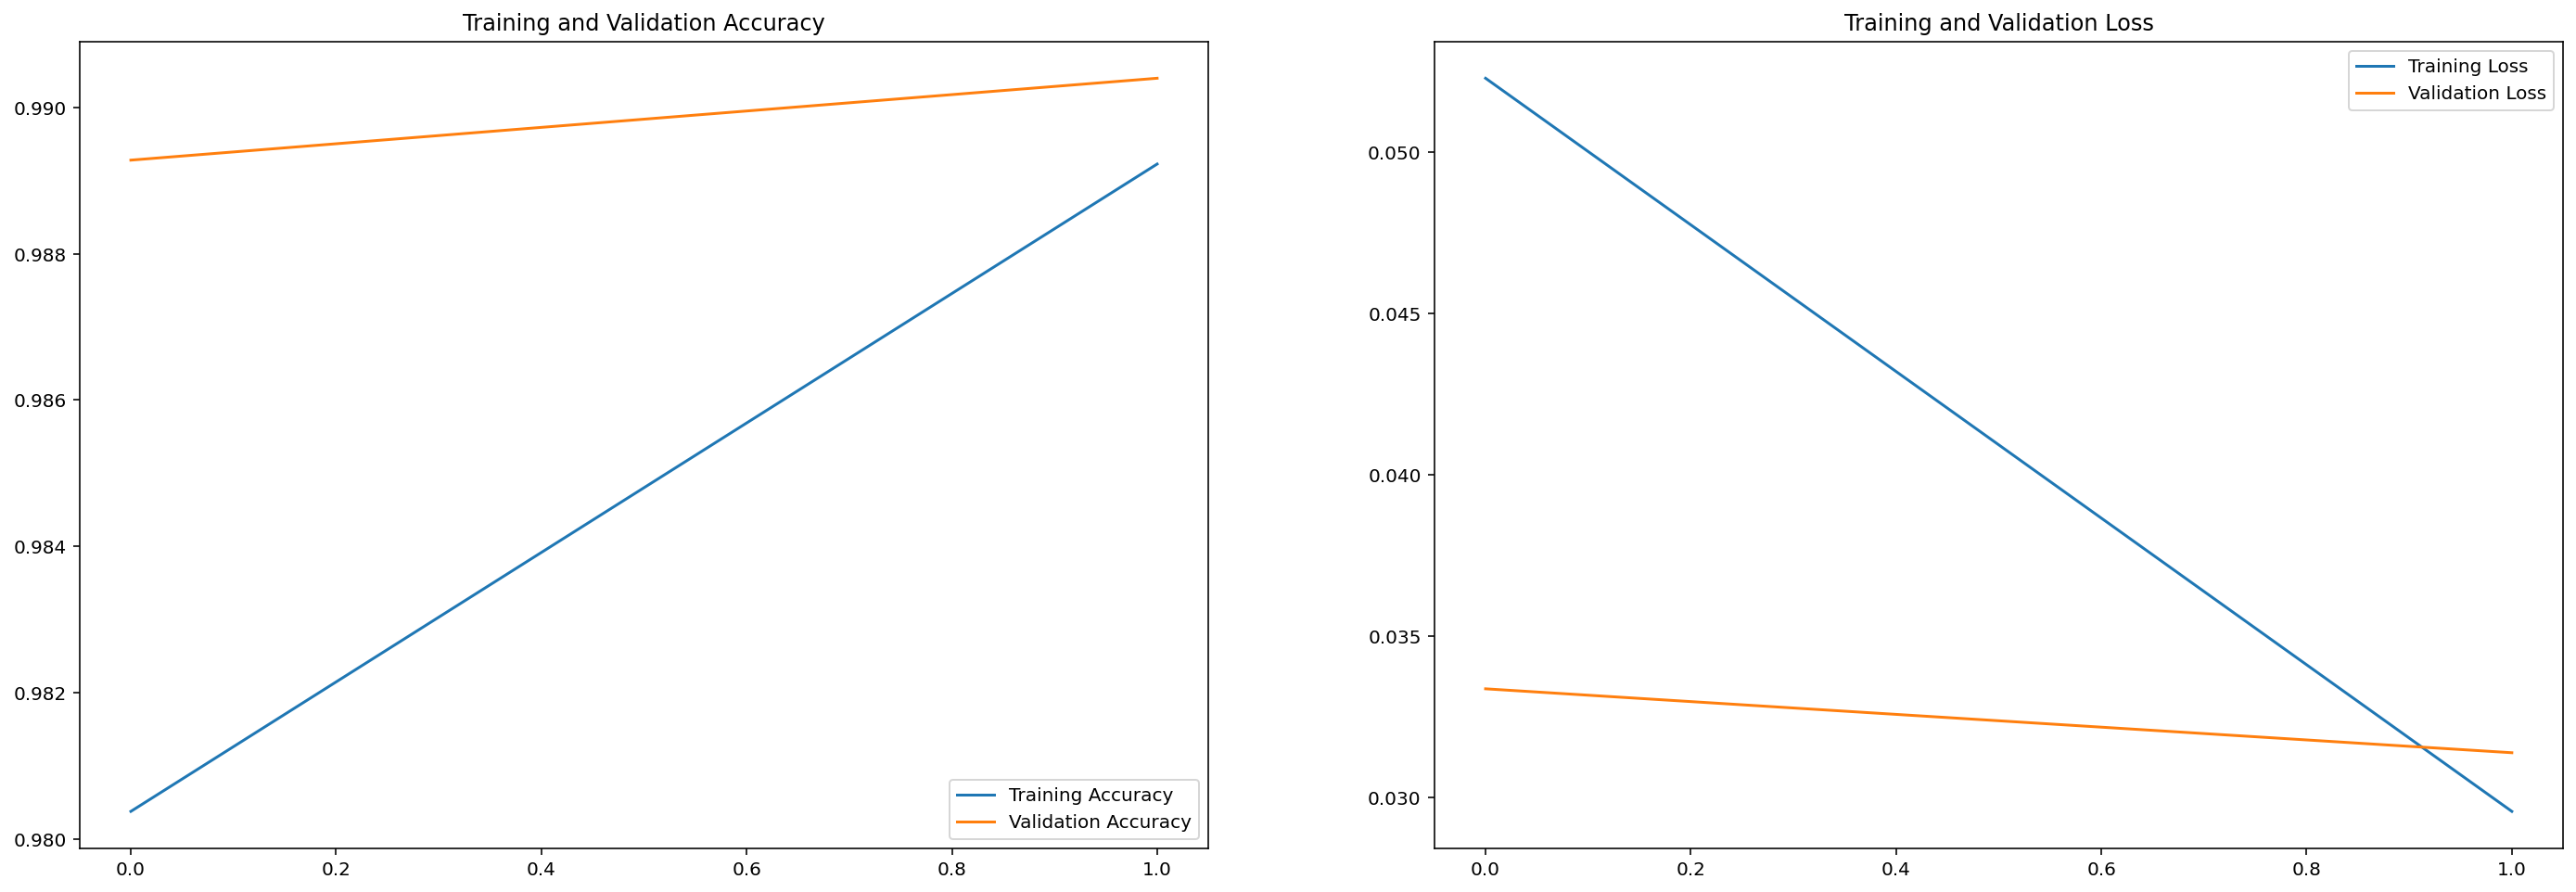

In [86]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [87]:
test_list = all_train_files[:100]
test_data_transform = data_transforms['val']

labels = []

with torch.no_grad():
    for test_path in tqdm(test_list):
        img = Image.open(test_path)
        img = test_data_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)

        model_ft.eval()
        outputs = model_ft(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        test_id = extract_class_from(test_path)
        labels.append(preds[0])

  0%|          | 0/100 [00:00<?, ?it/s]

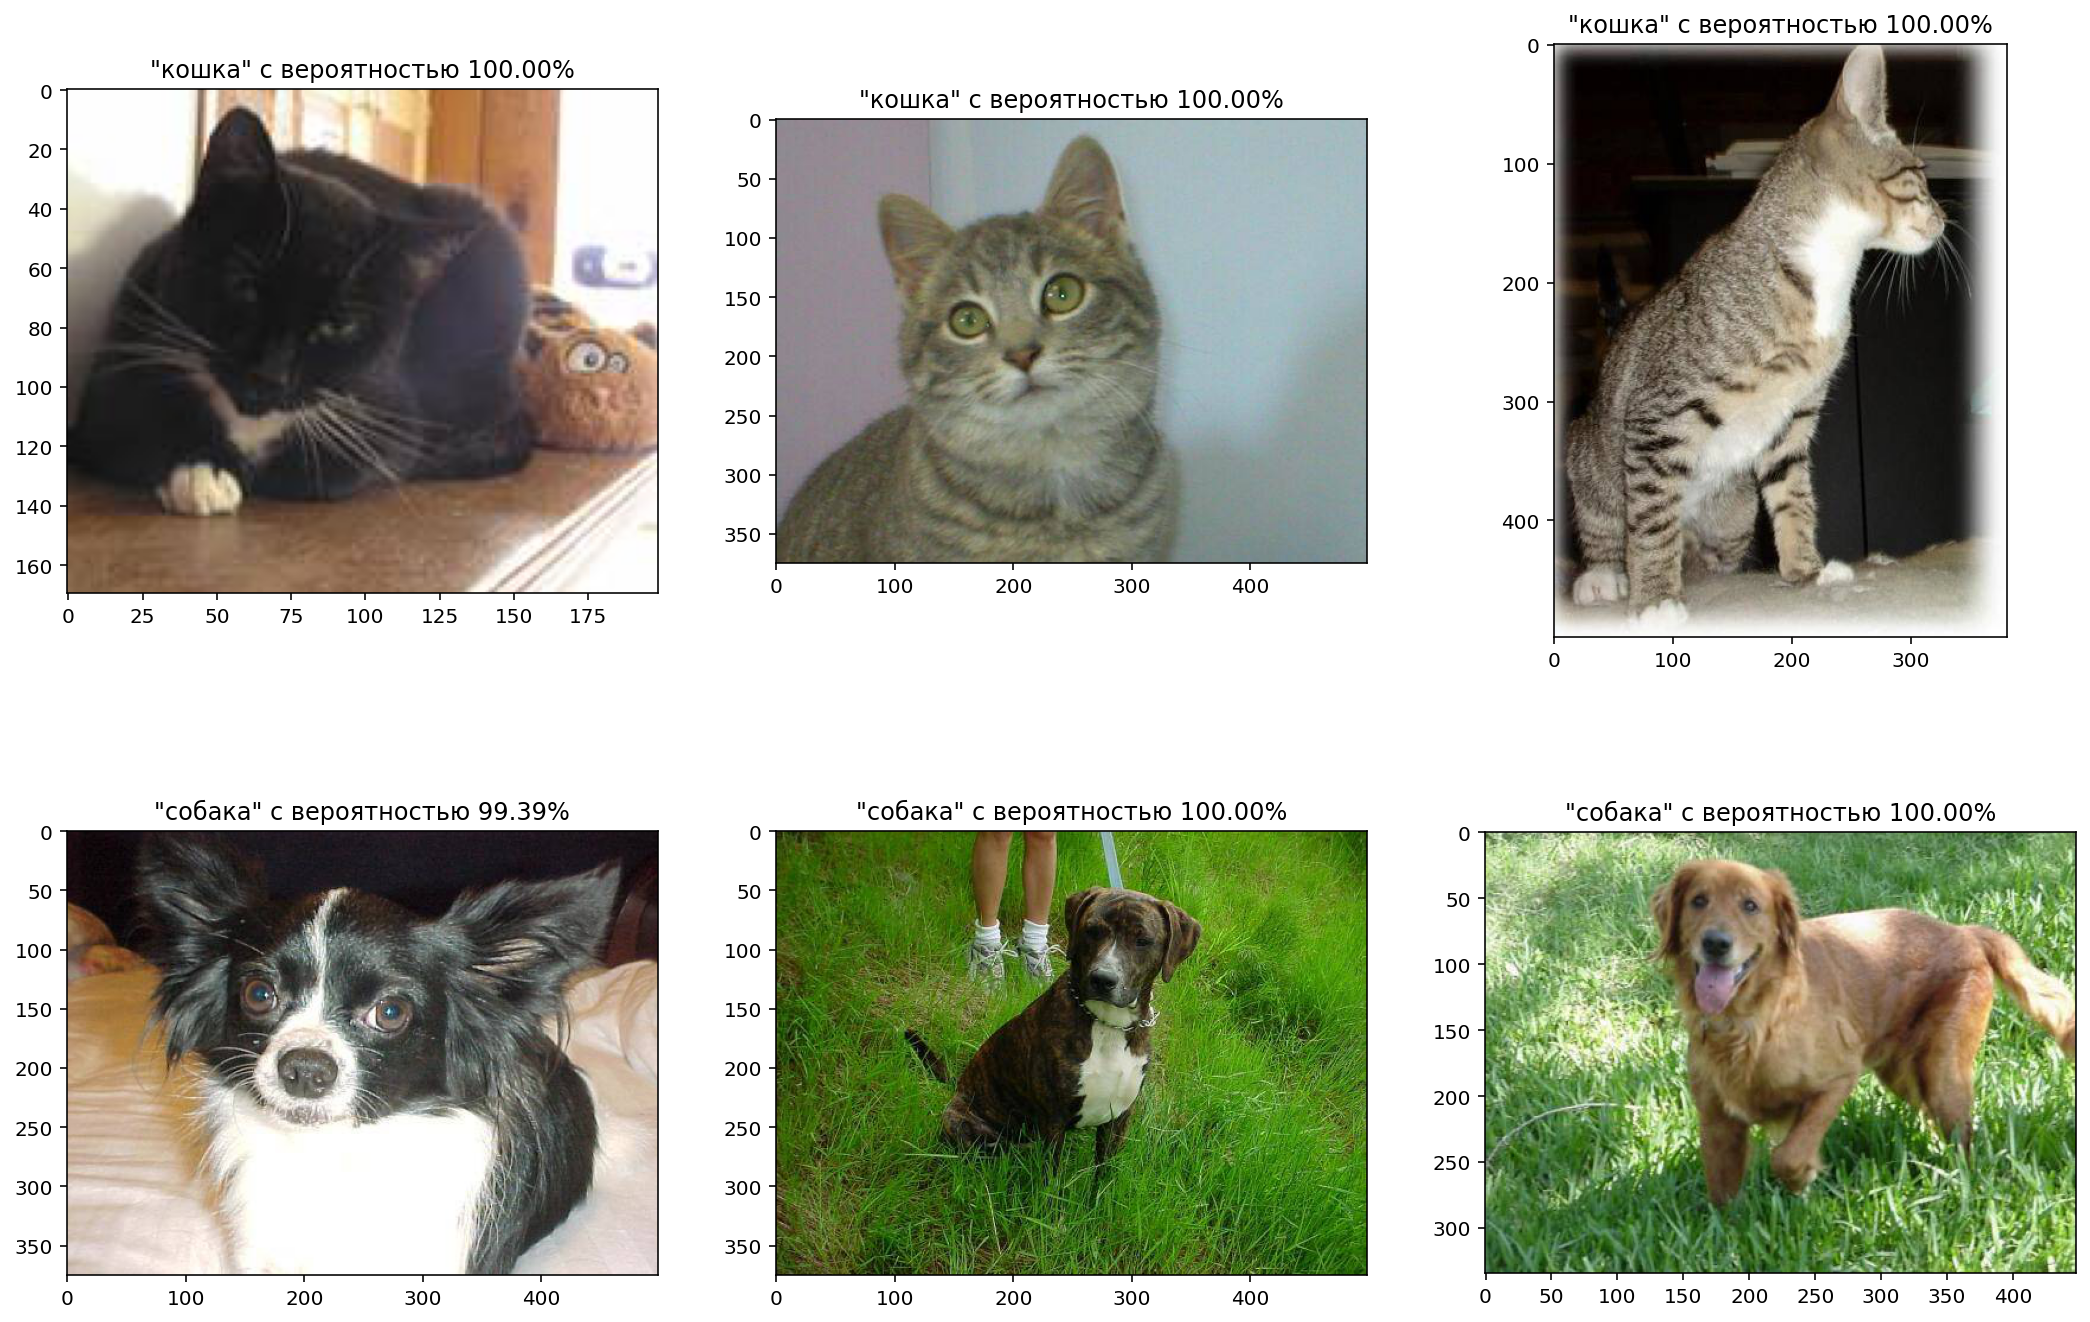

In [88]:
template = '"{}" с вероятностью {:.2%}'
def pred_result_message(pred):
    if pred > 0.5:
        return template.format('собака', pred)
    else:
        return template.format('кошка', 1 - pred)

fig, axes = plt.subplots(nrows=2,
                         ncols=3,
                         figsize=(18, 12))
for img_path, label, ax in zip(test_list, labels, axes.ravel()):
    ax.set_title(pred_result_message(label))
    ax.imshow(Image.open(img_path))

Видно, что довольно сложная задача решается весьма хорошо предобученной моделью. Здесь используются веса модели, которые выучены на классификации изображежний ImageNet. Предполагается, что такая предобученная модель способна выделять. качественные низкоуровневые признаки (а также достаточно высокоуровневые), которые используются добавленным слоем. Т.е таким образом не приходится обучать модель с самого начала, обучение происходит из достаточно хорошего начального приближения.